In [2]:
include("includes.jl");

### Setup

In [3]:
@everywhere measurements, measurements_mask = load_experiments()
@everywhere kid_id = 1 # 1 3 19 20 26 28
@everywhere n_measurements = length([1.51 4.06 7.06 9.90 12.66 15.40 15.58 18.56 21.38 24.36])#length(measurements[kid_id, measurements_mask[kid_id,:] .!= 0])

@everywhere prior = Normal(10,1)

@everywhere Θ₀ = [5*pi/180, 0]
@everywhere function dΘ(g)
    Θ -> [Θ[2], -g*sin(Θ[1])/8]
end

@everywhere grid = [0 1.51 4.06 7.06 9.90 12.66 15.40 15.58 18.56 21.38 24.36]#[0; measurements[kid_id,:][measurements_mask[kid_id,:] .!= 0]]

@everywhere loglikelihood = (n, g) ->
    let
        if n == 0
            return 0
        end
        
        _,y = ode45((t,u) -> [u[2]; -g[1]*sin(u[1])/8],Θ₀,grid[1:n+1],points=:specified)
        s = reduce((l,r)->l+r[1]^2, -y[1][1]^2, y)
    
        s2 = 0.035^2
    
        (s/s2, y[end][1]^2/s2)
    end

full_loglikelihood = g -> loglikelihood(n_measurements, g[1])[1];

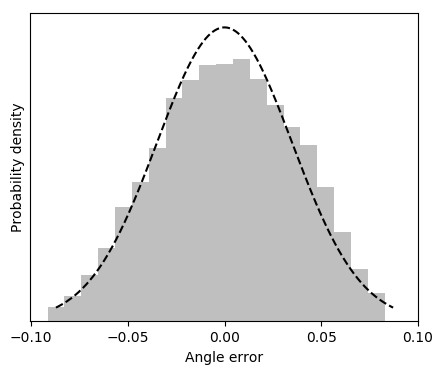

PyObject <matplotlib.text.Text object at 0x7fd517d879d0>

In [6]:
n= 1000
e = .5 # typical human reaction delay to images
X = zeros(n, n_measurements-1)
g = 9.86

for i=1:n
    perturbed_grid = grid[1:n_measurements] + (e^2)*randn(n_measurements)
    _,x = ode45((t,u) -> [u[2]; -g*sin(u[1])/8],Θ₀,perturbed_grid,points=:specified)
    X[i,:] = map(x -> x[1], x[2:end])
end
Y = sort(X[:]);

s=0.035

PyPlot.rc("figure", figsize=(5,4))

plt[:hist](X[:], bins=20, normed=true, alpha=0.5,histtype="stepfilled", color="grey", align="left", alpha=0.5);
plot(Y, exp.(-Y.^2/(2*s^2))/sqrt(2*pi*s^2),linestyle="--", color="black")

xticks([-0.1, -0.05, 0, 0.05, 0.1])
yticks([])

xlabel("Angle error")
ylabel("Probability density")

In [8]:

mesh = linspace(9,12,500)

els = zeros(n_measurements+1, 500)
for i=1:n_measurements+1
    lhood = (g -> -loglikelihood(i-1, g)[1] + Distributions.logpdf(prior, g)).(mesh)
    elhood = exp.(lhood)
    els[i,:] = elhood / sum(elhood)
end

m=findmax(els[end,:]);

In [ ]:
@time begin
    full_loglikelihood.()
end

In [16]:
mesh[m[2]]

9.781563126252506

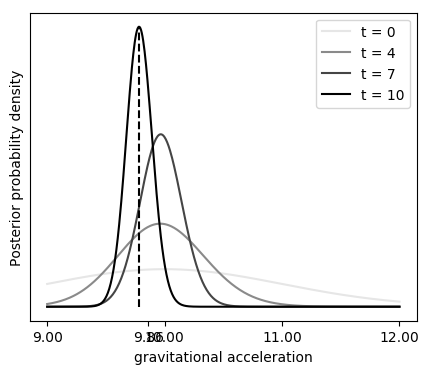

In [12]:
PyPlot.rc("figure", figsize=(5,4))
ns = 1+[0, 4, 7, n_measurements]
cs = linspace(0.9, 0, n_measurements+1) * [1,1,1]'
for i=1:4
    plot(mesh, els[ns[i],:], color=cs[ns[i],:],label="t = $(ns[i]-1)")
end

plot([mesh[m[2]], mesh[m[2]]], [0, m[1]], "--", c="black")

legend()
xlabel("gravitational acceleration")
ylabel("Posterior probability density")
yticks([])
xticks([9,9.86,10,11,12]);

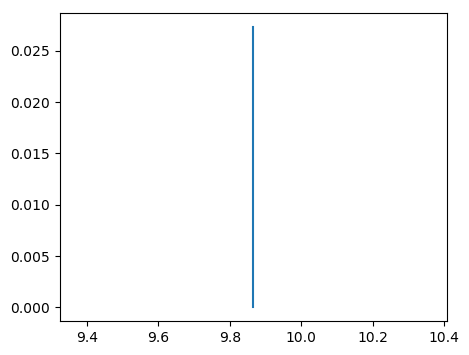

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fac9b976210>

In [30]:
plot([mesh[m[2]], mesh[m[2]]], [0, m[1]])


In [34]:
mesh[m[2]]

9.865731462925853

In [79]:
mesh = linspace(9.6,10.2,100000)


lhood = (g -> -loglikelihood(n_measurements, g)[1] + Distributions.logpdf(prior, g)).(mesh)
els = exp.(lhood)

vecdot(mesh, els)/sum(els)

9.868110019279865

### Metropolis Hastings with gaussian noise

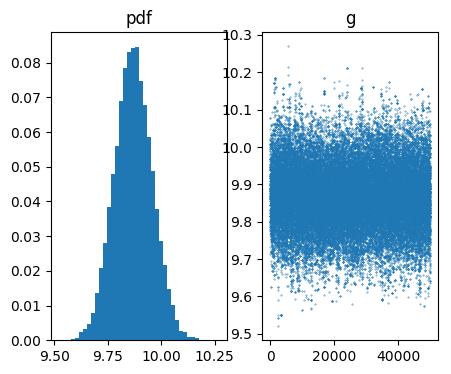

33463 / 50000 of the sampled particles were accepted (67.0%)
        
The expectation estimation is of 9.868091256897662


In [90]:
function GaussianMetropolisHastings(K, prior, ϕ, γ, warmup)
    x₀ = mean(prior)
    
    X = zeros(K-warmup, length(x₀))
    W = zeros(K-warmup)
    accepted = 0
    
    w = MvNormal(γ^2*eye(length(x₀)))
    x = x₀
    ϕₓ = ϕ(x)
    
    for k=1:K
        y = x + rand(w)
        ϕₙ = ϕ(y)
        if rand() < min(1, (pdf(prior, y[1])/pdf(prior, x[1]))*exp(ϕₓ-ϕₙ))
            x = y
            ϕₓ = ϕₙ
            if k > warmup
                accepted += 1
            end
        end
    
        if k > warmup
            W[k-warmup] = ϕₙ * pdf(prior, x[1])
            X[k-warmup,:] = x
        end
    end
    X, exp.(-W), accepted
end

out = GaussianMetropolisHastings(50_500, prior, full_loglikelihood, 0.1, 500);
plotMCMC(out)

In [33]:
means = zeros(5)
vars = zeros(5)

for i=1:5
    X,W,a = GaussianMetropolisHastings(10_500, prior, full_loglikelihood, 0.1, 500);
    means[i] = mean(X)
    vars[i] = var(X)
end

In [35]:
println(means)
var(means)

[9.86644, 9.8696, 9.86469, 9.86788, 9.86595]


3.5581276420964436e-6

### Sequential Monte Carlo with gaussian noise

In [4]:
function noop(n,W,X)
end

function GaussianSequentialMonteCarlo(X₀, p, prior, ll; μ=0.1,callback=noop,essratio=2,nrepeat=1)
    # initialization
    N,d = size(X₀)
    w = MvNormal(μ^2 * eye(d))

    X = SharedArray{Float64}(X₀)
    #dX = SharedArray{Float64,2}(X₀)
    
    #alphas = SharedArray{Float64}(N)
    W = SharedArray{Float64}(N)
    
    acceptance_rate = ones(p) ./ N
    ess = zeros(p)
    maxweights = zeros(p)
    minweights = zeros(p)
    
    # initialize
    s = @parallel (+) for i=1:N
        W[i] = exp(-ll(1, X[i,:])[1])
    end
    @sync @parallel for i=1:N
        W[i] /= s
    end
    
    for n = 1:p
        # update
        #copy!(dX, rand(w, N)')
        #rand!(alphas)
        
        @sync @parallel for i=1:N
            W[i] = log(W[i])
        end
        
        acceptance_rate[n] *= @parallel (+) for i=1:N
            accepted = 0
            
            xₙ₋₁ = X[i,:]
            xₙ = xₙ₋₁ + rand(w)

            wₙ,_= ll(n, xₙ)
            wₙ₋₁,ℓₙ₋₁ = ll(n, xₙ₋₁)
            
            W[i] -= ℓₙ₋₁
            
            for j = 1:nrepeat
                if rand() < min(1, exp(wₙ₋₁ - wₙ))
                    accepted += 1
                    X[i,:]=xₙ
                else
                    wₙ=wₙ₋₁
                end
                
                xₙ₋₁ = X[i,:]
                xₙ = xₙ₋₁ + rand(w)
                
                wₙ₋₁ = wₙ
                wₙ,_= ll(n, xₙ)
            end
            
            accepted
        end

        # normalize weights
        s = @parallel (+) for i=1:N
            W[i] = exp(W[i])
        end
        
        @sync @parallel for i=1:N
            W[i] /= s
        end
        
        minweights[n] = minimum(W)
        maxweights[n] = maximum(W)
        
        # resample
        ess[n] = 1 / vecdot(W,W)
        if ess[n] < N/essratio          
            perm = rand(Categorical(W[:]), N)
            @sync @parallel for i=1:N
                X[i,:] = X[perm[i], :]
                W[i] = 1/N
            end 
        end
        
        callback(n,W,X)
    end
    
    W,X,acceptance_rate,ess,minweights,maxweights
end

function GaussianSequentialImportanceSampling(X₀, p, prior, ll; μ=0.1, callback=noop,essratio=2)
    return GaussianSequentialMonteCarlo(X₀, p, prior, ll; μ=μ, callback=callback,essratio=size(X₀)[1]+1)
end

GaussianSequentialImportanceSampling (generic function with 1 method)

In [5]:
#PyPlot.rc("figure", figsize=(30,24))

N=5000
repeat=5

X₀ = reshape(rand(prior, N), N, 1)
outs = GaussianSequentialImportanceSampling(X₀, n_measurements, prior, loglikelihood, μ=0.5);


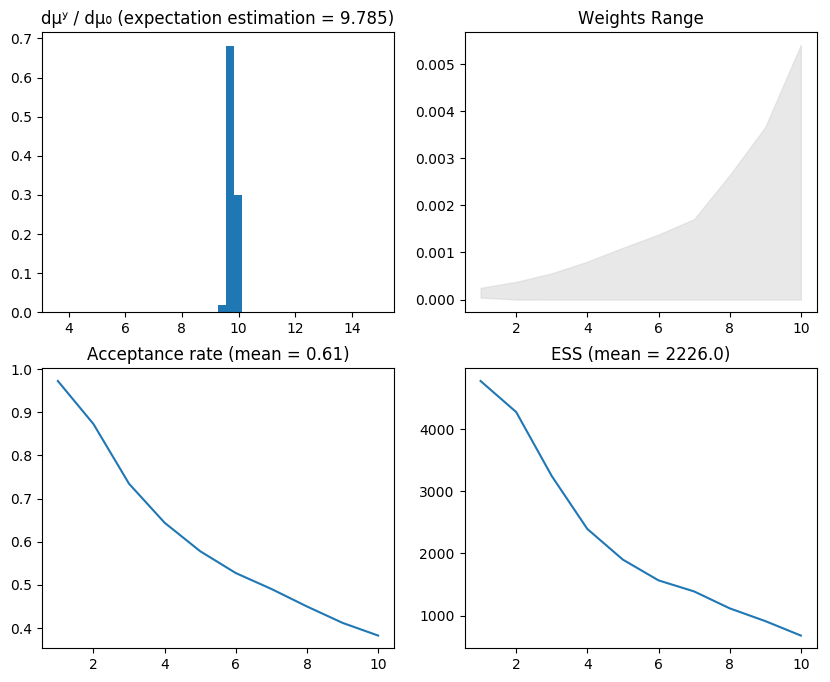

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f078bdfdd10>

In [6]:
plotSMC(outs)

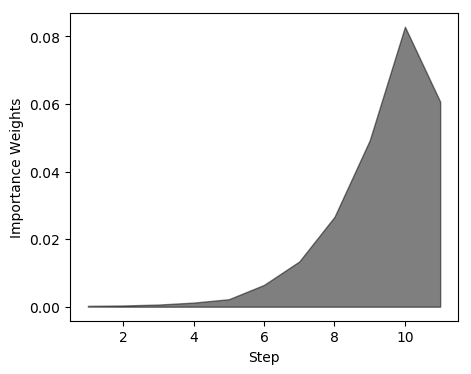

PyObject <matplotlib.text.Text object at 0x7f77e6f85c10>

In [65]:
PyPlot.rc("figure", figsize=(5,4))

W,X,acceptance_rate,ess,minweights,maxweights = outs

fill_between(1:n_measurements, minweights, maxweights, color="black", alpha=0.5)
ylabel("Importance Weights")
xlabel("Step")
#xticks([])

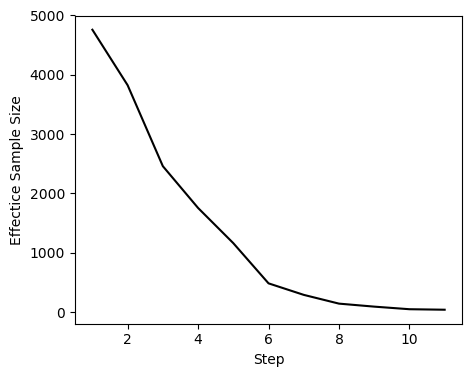

PyObject <matplotlib.text.Text object at 0x7f77d10c5a50>

In [64]:
PyPlot.rc("figure", figsize=(5,4))

W,X,acceptance_rate,ess,minweights,maxweights = outs

plot(1:repeat*n_measurements, ess, color="black")
ylabel("Effectice Sample Size")
xlabel("Step")
#xticks([])

In [6]:
function mksaveprogress(directory,name)
    function saveprogress(n,w,x)
        writedlm("$directory/$name/$n", [w, x])
    end
    
    if !isdir(directory)
        mkdir(directory)
    end
    
    if !isdir("$directory/$name")
        mkdir("$directory/$name")
    end
    
    return saveprogress
end



function mkplotprogress(ll,n_repeat,n_measurements)
    function plotprogress(n,w,x)
        ax = subplot(n_measurements,n_repeat,n) 
        PyPlot.plt[:hist](x, 40, weights=w)
        mesh = linspace(9.7, 9.9, 200)
        posterior = exp.((g -> -ll(n,g)[1] + Distributions.logpdf(prior, g)).(mesh))
        posterior /= sum(w)
        plot(mesh, posterior)

        ax[:set_yticklabels]([])
        ax[:set_xticklabels]([])
    end
    return plotprogress
end

mkplotprogress (generic function with 1 method)

In [2]:
means = zeros(7,40)
vars = zeros(7,40)

j = 1
for lN in 10:15
    N  = 2^lN
    for i = 1:40
        data = readdlm("results/16-05-2018/N_$(N)_kid_1_MCMC_5/$i")
        
        means[j,i] = vecdot(data[1,:], data[2,:])
        vars[j,i] = vecdot(data[1,:], (data[2,:] - means[j,i]).^2)
    end
    j += 1
end

for lN in [16]
    N  = 2^lN
    for i = 1:20
        data = readdlm("results/16-05-2018/N_$(N)_kid_1_MCMC_5/$i")
        
        means[j,i] = vecdot(data[1,:], data[2,:])
        vars[j,i] = vecdot(data[1,:], (data[2,:] - means[j,i]).^2)
        
        means[j,i+20] = vecdot(data[1,:], data[2,:])
        vars[j,i+20] = vecdot(data[1,:], (data[2,:] - means[j,i+20]).^2)
    end
    j += 1
end

In [4]:
using PyPlot

PyPlot.rc("figure", figsize=(5,4))

m = mean(means,2)[:]
ma = maximum(means,2)[:]
mi = minimum(means,2)[:]



v = mean(vars,2)[:]
va = maximum(vars,2)[:]
vi = minimum(vars,2)[:]

NS = 2.^(10:16);

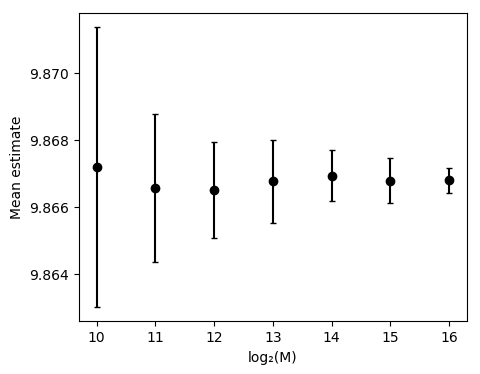

PyObject <matplotlib.text.Text object at 0x7fdcfeb7b510>

In [5]:
errorbar(log2.(NS), m, yerr=std(means,2),fmt="o", c="black", ecolor="black", capsize=2)
xlabel("log₂(M)")
ylabel("Mean estimate")

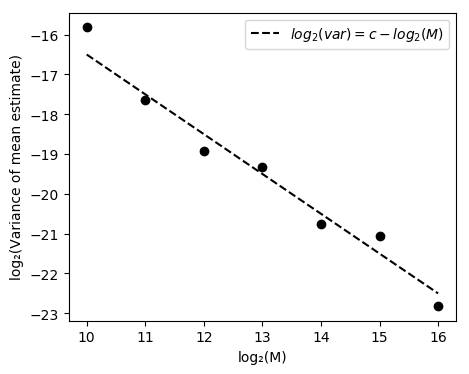

PyObject <matplotlib.text.Text object at 0x7fdcebc1fd10>

In [32]:
scatter(log2.(NS), log2.(var(means,2)), c="black",)
plot(log2.(NS), -6.5 - log2.(NS), c="black", linestyle="--",label=L"log_2(var) = c - log_2(M)")

legend()
xlabel("log₂(M)")
ylabel("log₂(Variance of mean estimate)")

# Gen data

In [170]:
nrepeat = 5

#mkdir("results/17-05-2018")
for lN in [14]#10:15#[1000, 2000, 5000, 10_000, 25_000, 50_000, 75_000, 100_000]
    N = 2^lN
    dir = "results/16-05-2018/N_$(N)_kid_$(kid_id)_MCMC_$(nrepeat)"
    #mkdir(dir)
    for i = 21:40
        X₀ = reshape(rand(prior, N), N, 1)    
        
        W,X,A,ESS,d,u = GaussianSequentialMonteCarlo(X₀, n_measurements, prior, loglikelihood,
                                                     μ=0.5, nrepeat=nrepeat);
        writedlm("$dir/$i", [W, X, A, ESS])
    end
end

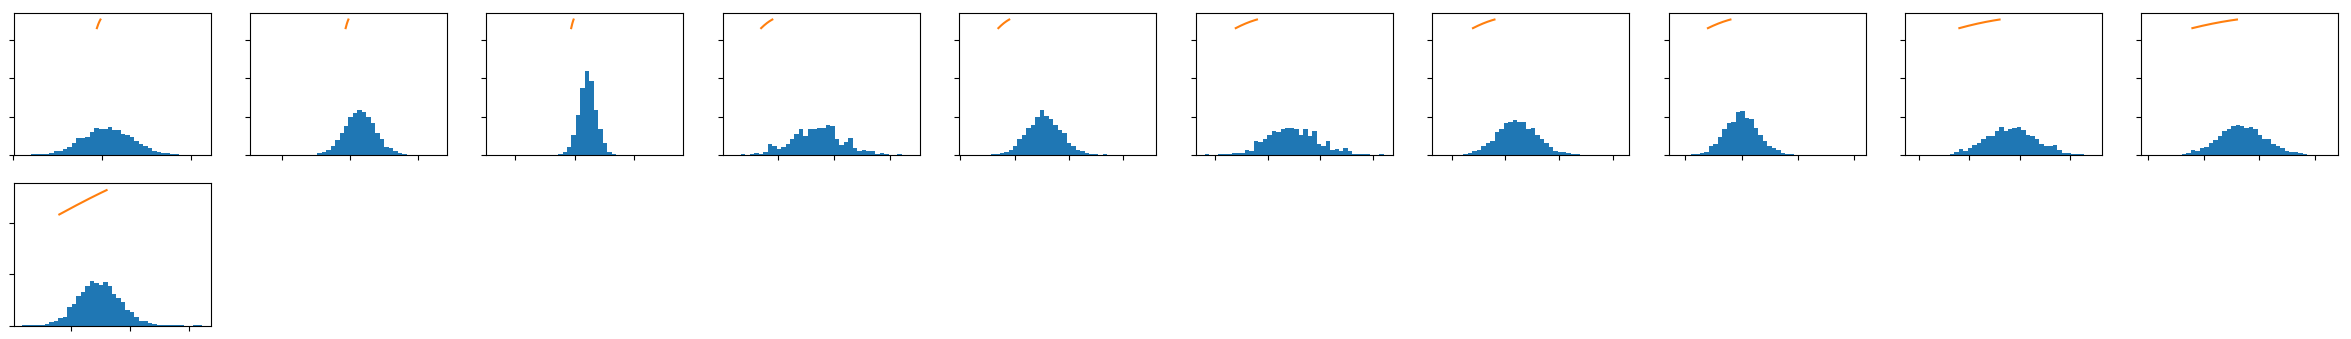

In [93]:
PyPlot.rc("figure", figsize=(20,16))

N=5000
plotprogress = mkplotprogress(modulo_llhood, repeat, n_measurements)

X₀ = reshape(rand(prior, N), N, 1)
outs = GaussianSequentialMonteCarlo(X₀, n_measurements, prior, loglikelihood, μ=0.5,nrepeat=5,callback=plotprogress);

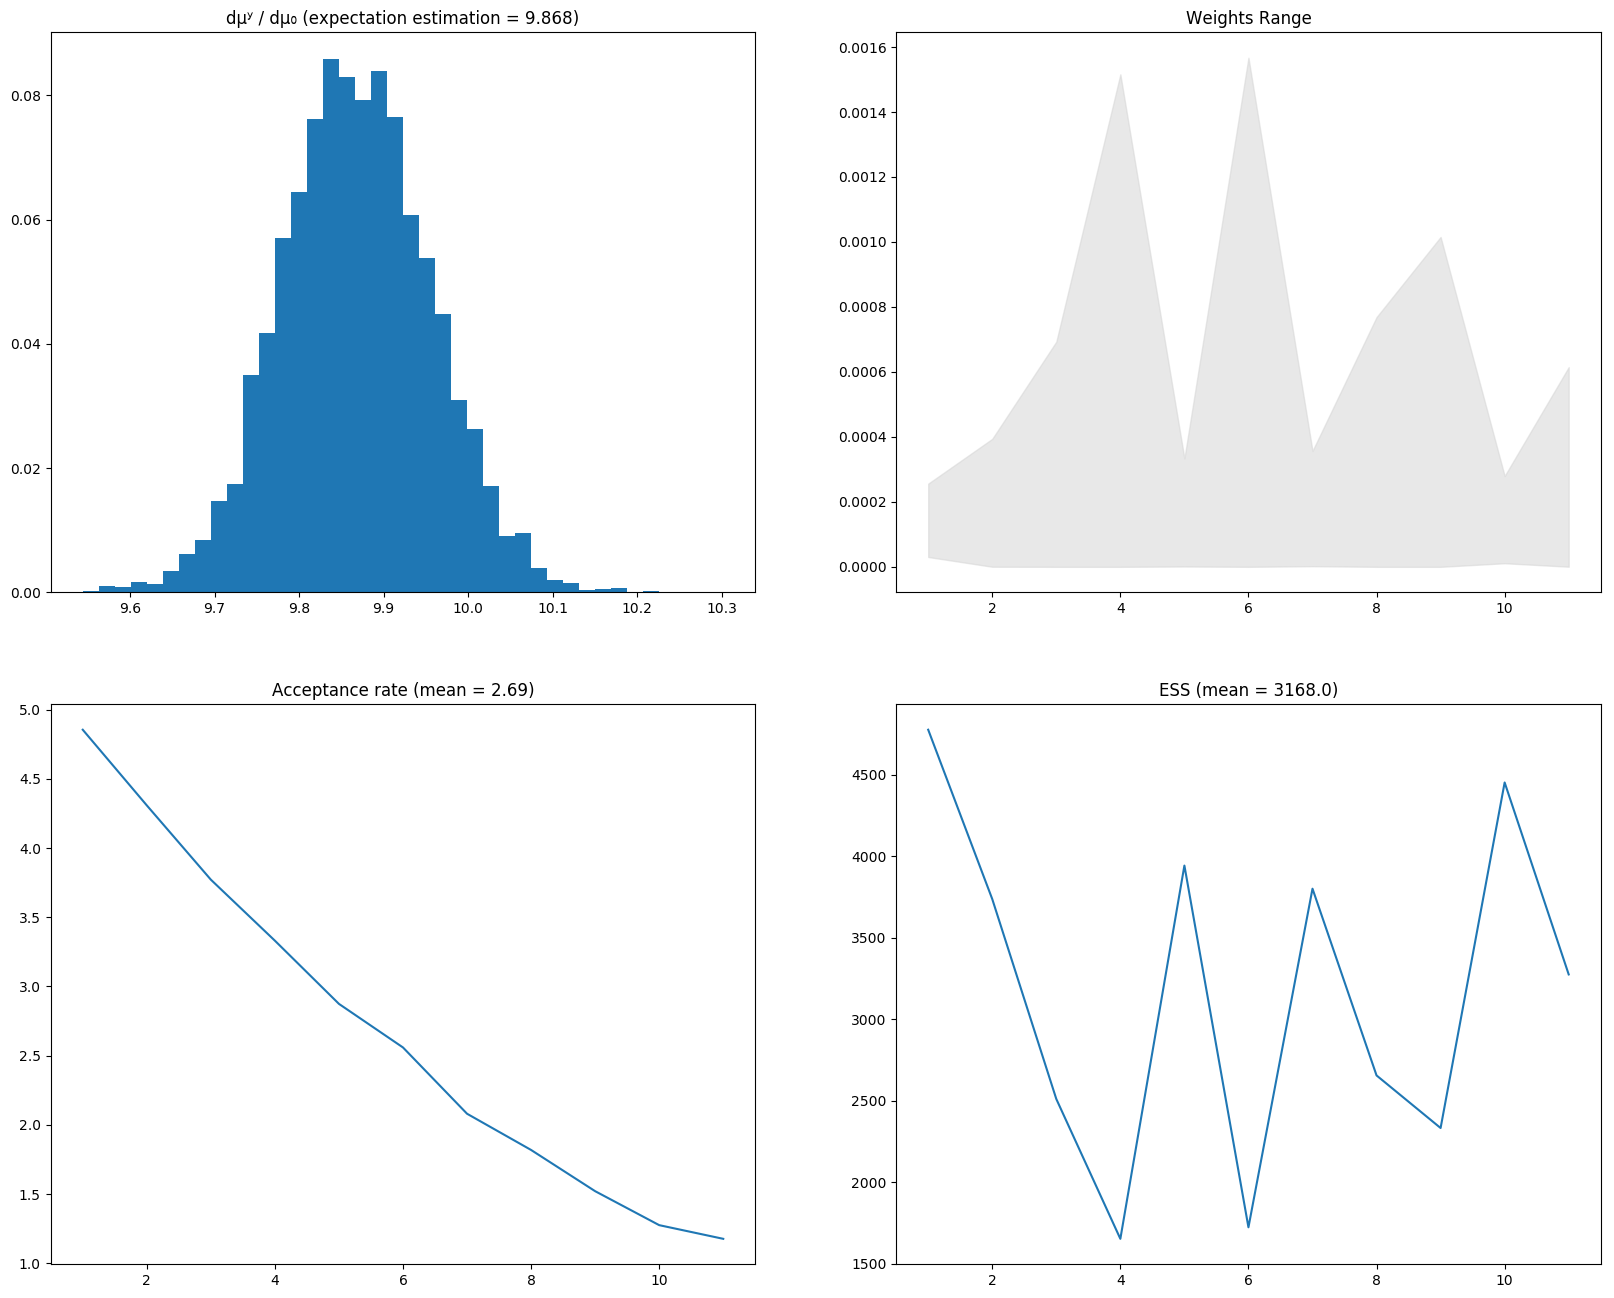

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f77cebc5590>

In [94]:
plotSMC(outs)